In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

C:\Users\nelli\anaconda3\envs\Deep2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import dask
#from dask_saturn import SaturnCluster
from dask.distributed import Client
#from distributed.worker import logger

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [5]:
#n_workers = 3
#cluster = SaturnCluster(n_workers=n_workers)
#client = Client(cluster)
#client.wait_for_workers(n_workers)

client = Client()

In [6]:
# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

In [7]:
import datetime

@dask.delayed
def train(experiment):
    # experiment
    batch_size, learning_rate = experiment
    train_loader = torch.utils.data.DataLoader(training_data,batch_size)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size)
    
    device = torch.device('cuda:0')
    num_epochs = 5
    count = 0
    model = FashionCNN()
    model.to(device)
    error = nn.CrossEntropyLoss()
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
    
    
    training_start_time = datetime.datetime.now()
    # print out
    results = []

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            train = Variable(images.view(100, 1, 28, 28))
            labels = Variable(labels)
            outputs = model(train)
            loss = error(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count += 1

        # Testing the model
            if not (count % 50):    # It's same as "if count % 50 == 0"
                total = 0
                correct = 0
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
                    test = Variable(images.view(100, 1, 28, 28))
                    outputs = model(test)
                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()
                    total += len(labels)
                    
                accuracy = correct * 100 / total   
                new_results = {
                   "batch_size": batch_size,
                   "loss": loss.data.item(),
                   "iteration": count,
                   "accuracy": accuracy.item(),
                   "elapsed_time_sec": (datetime.datetime.now() - training_start_time).total_seconds(),
                }
                results.append(new_results)  
   
    return results

In [8]:
#list of experiments (batch_size, learning_rate)
#inputs = [(100, 0.001), (100, 0.001), (100, 0.001), (100, 0.001)]
experiments = [(100, 0.001)]
train_future = client.map(train, experiments)

In [9]:
futures_gathered = client.gather(train_future)

In [10]:
futures_computed = client.compute(futures_gathered)

In [11]:
results = [x.result() for x in futures_computed]

In [16]:
import pandas as pd

results_concatenated = [item for sublist in results for item in sublist]
results_df = pd.DataFrame.from_dict(results_concatenated)
results_df.head(10)

,batch_size,loss,iteration,accuracy,elapsed_time_sec
0,100,0.446040,50,80.779999,4.762428
1,100,0.545907,100,82.389999,8.147475
2,100,0.513924,150,85.379997,11.207155
3,100,0.406646,200,86.110001,14.164868
4,100,0.388509,250,84.759995,16.760471
5,100,0.372058,300,86.860001,19.718247
6,100,0.360087,350,86.970001,22.391748
7,100,0.461946,400,83.979996,25.316237
8,100,0.668416,450,84.930000,28.051320
9,100,0.486805,500,87.669998,30.677633


In [17]:
results_df.tail()

,batch_size,loss,iteration,accuracy,elapsed_time_sec
55,100,0.294967,2800,90.099998,158.686704
56,100,0.458460,2850,89.939995,161.465027
57,100,0.235022,2900,90.409996,164.436711
58,100,0.153714,2950,90.029999,167.063556
59,100,0.156465,3000,90.570000,169.751957


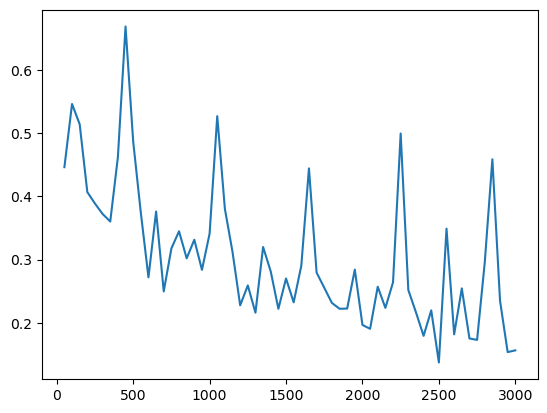

In [13]:
import matplotlib.pyplot as plt

plt.plot(results_df['iteration'], results_df['loss'])
plt.show()

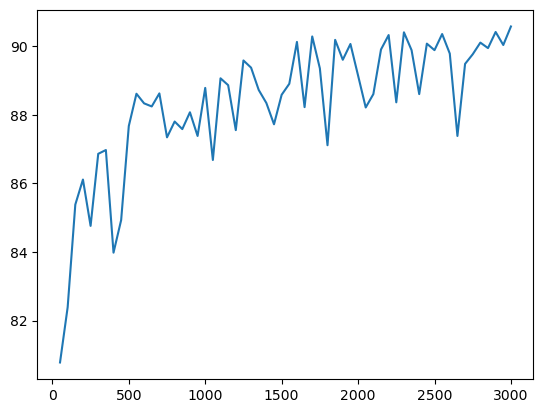

In [14]:
plt.plot(results_df['iteration'], results_df['accuracy'])
plt.show()

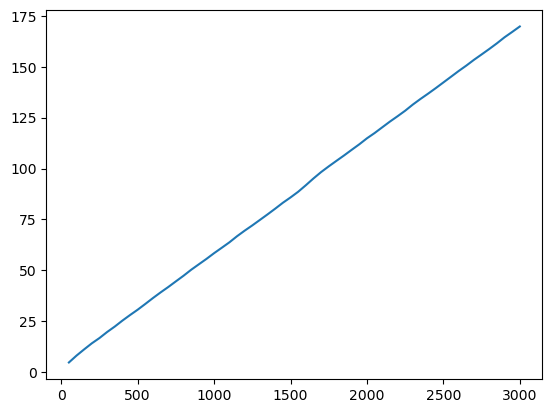

In [15]:
plt.plot(results_df['iteration'], results_df['elapsed_time_sec'])
plt.show()